In [1]:
#!/usr/bin/env python3
from sklearn.metrics import roc_auc_score
import numpy as np
import model
import yaml
from imutils import face_utils
import dlib
import cv2
import torch
import torch.nn as nn
from collections import OrderedDict


In [2]:
def load_checkpoint(ckpt, net, device):
    checkpoint = torch.load(ckpt)

    gpu_state_dict = OrderedDict()
    for k, v in checkpoint['network'] .items():
        name = "module." + k  # add `module.` prefix
        gpu_state_dict[name] = v.to(device)
    net.load_state_dict(gpu_state_dict)
    return net

def load_config(config_file):
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    return config


MEAN_FACE = np.array([
    [-0.17607, -0.172844],  # left eye pupil
    [0.1736, -0.17356],  # right eye pupil
    [-0.00182, 0.0357164],  # nose tip
    [-0.14617, 0.20185],  # left mouth corner
    [0.14496, 0.19943],  # right mouth corner
])


def align_5p(
        images, ld, face_width, canvas_size,
        translation=[0, 0], rotation=0,
        scale=1, sa=1, sb=1
):
    '''crop face with landmark.

    images: input images. -> ndarray.
    ld: face landmark of input images. -> ndarray; shape -> (5, 2)
    face_width: face width ratio of the cropped images. -> float
    canvas_size: shape of the cropped face.
    return list of cropped images. -> list(ndarray)
    '''
    nose_tip = ld[30]
    left_eye = np.mean(ld[36:42], axis=0).astype('int')
    right_eye = np.mean(ld[42:48], axis=0).astype('int')
    left_mouth, right_mouth = ld[48], ld[54]

    lm = np.array([left_eye, right_eye, nose_tip, left_mouth, right_mouth])

    mf = MEAN_FACE * scale
    mf = get_mean_face(mf, face_width, canvas_size)

    M1 = np.eye(3)
    M1[:2] = get_align_transform(lm, mf)

    M2 = np.eye(3)
    M2[:2] = cv2.getRotationMatrix2D((canvas_size/2, canvas_size/2), rotation, 1)

    def stretch(va, vb, s):
        m = (va+vb)*0.5
        d = (va-vb)*0.5
        va[:] = m+d*s
        vb[:] = m-d*s

    mf = mf[[0, 1, 3, 4]].astype(np.float32)
    mf2 = mf.copy()
    stretch(mf2[0], mf2[1], sa)
    stretch(mf2[2], mf2[3], 1.0/sa)
    stretch(mf2[0], mf2[2], sb)
    stretch(mf2[1], mf2[3], 1.0/sb)

    mf2 += np.array(translation)

    M3 = cv2.getPerspectiveTransform(mf, mf2)

    M = M3.dot(M2).dot(M1)

    dshape = (canvas_size, canvas_size)
    images = [cv2.warpPerspective(img, M, dshape) for img in images]

    # warp landmark.
    ld = np.array(ld)
    ld = ld.dot(M[:, :2].T) + M[:, 2].T

    return images, ld[:, :2]


def get_mean_face(mf, face_width, canvas_size):
    ratio = face_width / (canvas_size * 0.34967)
    left_eye_pupil_y = mf[0][1]
    ratioy = (left_eye_pupil_y * ratio + 0.5) * (1 + 1.42)
    mf[:, 0] = (mf[:, 0] * ratio + 0.5) * canvas_size
    mf[:, 1] = (mf[:, 1] * ratio + 0.5) * canvas_size / ratioy

    return mf

def get_align_transform(lm, mf):
    mx = mf[:, 0].mean()
    my = mf[:, 1].mean()
    dmx = lm[:, 0].mean()
    dmy = lm[:, 1].mean()

    ux = mf[:, 0] - mx
    uy = mf[:, 1] - my
    dux = lm[:, 0] - dmx
    duy = lm[:, 1] - dmy
    c1 = (ux * dux + uy * duy).sum()
    c2 = (ux * duy - uy * dux).sum()
    c3 = (dux**2 + duy**2).sum()
    a = c1 / c3
    b = c2 / c3

    kx, ky = 1, 1

    transform = np.zeros((2, 3))
    transform[0][0] = kx * a
    transform[0][1] = kx * b
    transform[0][2] = mx - kx * a * dmx - kx * b * dmy
    transform[1][0] = -ky * b
    transform[1][1] = ky * a
    transform[1][2] = my - ky * a * dmy + ky * b * dmx
    return transform


def prepare_test_input(img, ld, label, config):
    config = config['crop_face']

    img, ld = align_5p(
        img, ld=ld,
        face_width=config['face_width'], canvas_size=config['output_size'],
        scale=config['scale']
    )
    return img, {'label': label}

def inference(img_path):
    frame = cv2.imread(img_path)
    height, width = frame.shape[:-1]

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = face_detector(frame, 1)
    if len(faces) == 0:
        tqdm.write('No faces in {}:{}'.format(cnt_frame, os.path.basename(video_path)))
        print("Supposed to continue")
    landmarks = list()  # save the landmark
    size_list = list()  # save the size of the detected face
    for face_idx in range(len(faces)):
        landmark = face_predictor(frame, faces[face_idx])
        landmark = face_utils.shape_to_np(landmark)
        x0, y0 = landmark[:, 0].min(), landmark[:, 1].min()
        x1, y1 = landmark[:, 0].max(), landmark[:, 1].max()
        face_s = (x1 - x0) * (y1 - y0)
        size_list.append(face_s)
        landmarks.append(landmark)
        
        if face_idx > 0:
            print("More faces found oops")

    label = 1
    img = cv2.imread(test_img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, label_dict = prepare_test_input(
                    [img], np.array(landmark), label, cfg
                )
    face_img = img.copy()
    img = torch.Tensor(img[0].transpose(2, 0, 1))
    from torch.utils.data import DataLoader
    test_loader = DataLoader(img,
                                batch_size=1,
                                shuffle=True, num_workers=1,
                                )

    outputs = net(img.unsqueeze(0))
    return outputs, face_img

#### Load models and config

In [3]:
cfg = load_config('./configs/caddm_test.cfg')

model_path = './checkpoints/efficientnet-b3.pkl'
model_backbone = "efficientnet-b3"
PREDICTOR_PATH = "./lib/shape_predictor_81_face_landmarks.dat"

################################# LOAD DEEP FAKE MODEL #################################

net = model.get(backbone="efficientnet-b3")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
net = nn.DataParallel(net)
net.eval()

net = load_checkpoint(model_path, net, device)

################################# LOAD FACE DETECTOR MODEL #################################
face_detector = dlib.get_frontal_face_detector()
face_predictor = dlib.shape_predictor(PREDICTOR_PATH)

Loaded pretrained weights for efficientnet-b3


More faces found oops
tensor([[0.8979, 0.1021]], grad_fn=<SoftmaxBackward0>)


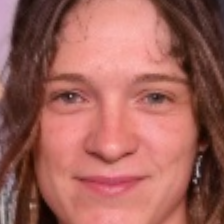

In [4]:
from PIL import Image
test_img_path = '/Users/akhilmehta/Desktop/kay/git/deepfake-detection/data/image/test/faceswap/celebrity/fake/tomholland_8.jpg'
outputs, face_img = inference(test_img_path)
print(outputs)
Image.fromarray(face_img[0])